In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [3]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hi I am Krish"}

In [4]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

In [5]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Krish'}

In [8]:
try:
    graph.invoke({"a":123})  #should be a string
except Exception as e:
    print("Exception was raised because a value iss integer")

Exception was raised because a value iss integer


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [9]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a": 123  # Invalid
    }

def ok_node(state:OverallState):
    return {"a":"goodbye"}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()





In [11]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

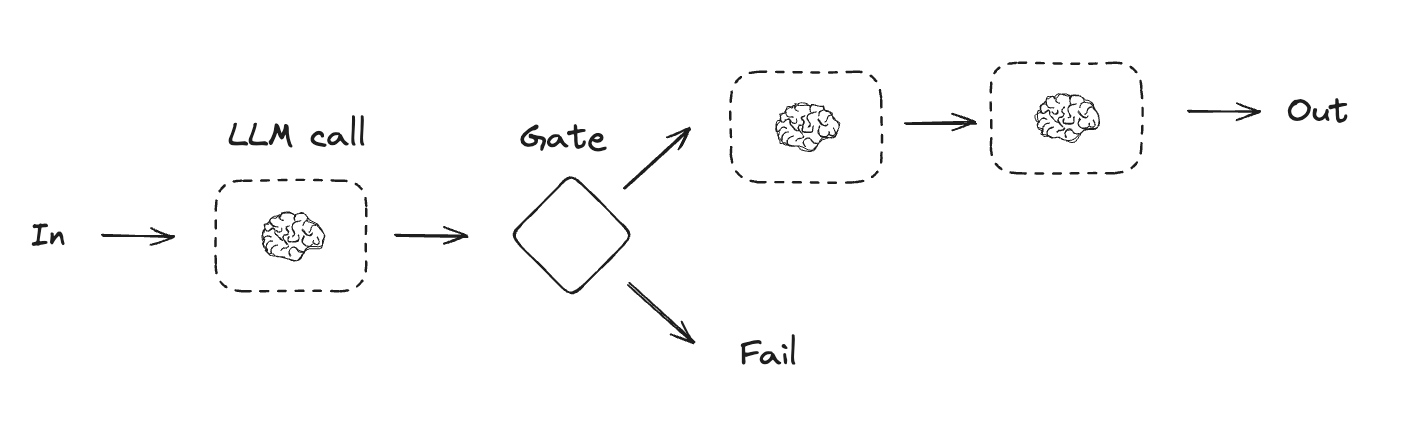

In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003684326, 'queue_time': 0.23698870100000002, 'total_time': 0.053684326}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-232f2cb5-e424-40e3-b9c2-d5573ca8979b-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [14]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



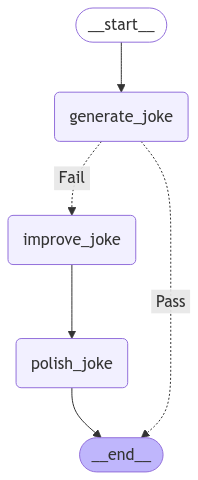

In [16]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [17]:
# Invoke
state = chain.invoke({"topic": "cats"})

In [18]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': 'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision!',
 'final_joke': 'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision! But it gets even more surprising when you find out that the real reason is one clever cheetah who learned to bluff so well, it convinced everyone it was a royal flush of spots every time, and now it’s the only one at the poker table who knows when the others are really holding great hands or not!'}